loss: 0.8129	 accuracy: 0.42
loss: 0.5576	 accuracy: 0.995
loss: 0.4194	 accuracy: 1.0
loss: 0.3356	 accuracy: 1.0
loss: 0.2806	 accuracy: 1.0
loss: 0.2421	 accuracy: 1.0
loss: 0.2137	 accuracy: 1.0
loss: 0.1918	 accuracy: 1.0
loss: 0.1746	 accuracy: 1.0
loss: 0.1606	 accuracy: 1.0


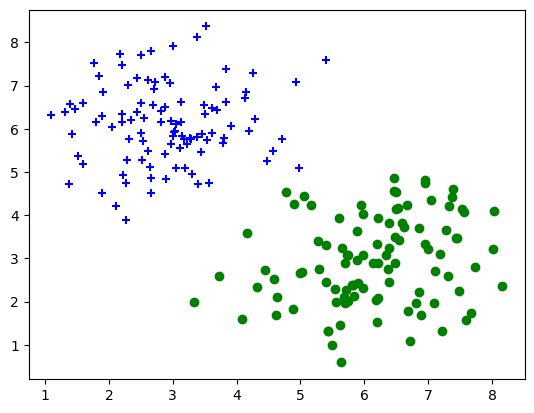

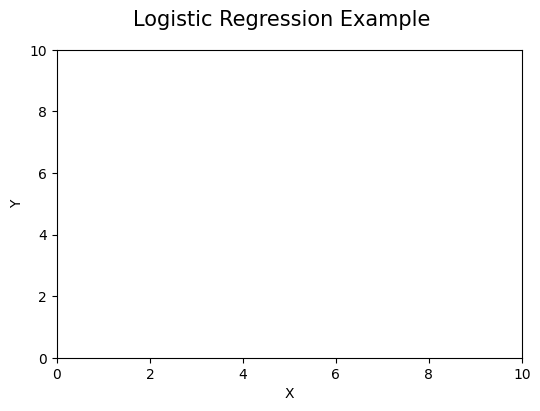

In [4]:
#!/usr/bin/env python
# coding: utf-8

# # Logistic Regression Example

# ### 生成数据集， 看明白即可无需填写代码
# #### '<font color="blue">+</font>' 从高斯分布采样 (X, Y) ~ N(3, 6, 1, 1, 0).<br>
# #### '<font color="green">o</font>' 从高斯分布采样  (X, Y) ~ N(6, 3, 1, 1, 0)<br>

import tensorflow as tf
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.cm as cm
import numpy as np

# get_ipython().run_line_magic('matplotlib', 'inline')

dot_num = 100
x_p = np.random.normal(3., 1, dot_num)
y_p = np.random.normal(6., 1, dot_num)
y = np.ones(dot_num)
C1 = np.array([x_p, y_p, y]).T

x_n = np.random.normal(6., 1, dot_num)
y_n = np.random.normal(3., 1, dot_num)
y = np.zeros(dot_num)
C2 = np.array([x_n, y_n, y]).T

plt.scatter(C1[:, 0], C1[:, 1], c='b', marker='+')
plt.scatter(C2[:, 0], C2[:, 1], c='g', marker='o')

data_set = np.concatenate((C1, C2), axis=0)
np.random.shuffle(data_set)

# ## 建立模型
# 建立模型类，定义loss函数，定义一步梯度下降过程函数

epsilon = tf.constant(1e-12, dtype=tf.float32)


class LogisticRegression():
    def __init__(self):
        self.W = tf.Variable(shape=[2, 1], dtype=tf.float32,
                             initial_value=tf.random.uniform(shape=[2, 1], minval=-0.1, maxval=0.1))
        self.b = tf.Variable(shape=[1], dtype=tf.float32, initial_value=tf.zeros(shape=[1]))

        self.trainable_variables = [self.W, self.b]

    @tf.function
    def __call__(self, inp):
        inp = tf.cast(inp, tf.float32)  # 确保输入数据类型为 float32
        logits = tf.matmul(inp, self.W) + self.b  # shape(N, 1)
        pred = tf.nn.sigmoid(logits)
        return pred


@tf.function
def compute_loss(pred, label):
    if not isinstance(label, tf.Tensor):
        label = tf.constant(label, dtype=tf.float32)
    pred = tf.squeeze(pred, axis=1)
    '''============================='''
    # 输入label shape(N,), pred shape(N,)
    # 输出 losses shape(N,) 每一个样本一个loss
    # todo 填空一，实现sigmoid的交叉熵损失函数(不使用tf内置的loss 函数)
    losses = - (label * tf.math.log(pred + epsilon) + (1 - label) * tf.math.log(1 - pred + epsilon))
    '''============================='''
    loss = tf.reduce_mean(losses)

    pred = tf.where(pred > 0.5, tf.ones_like(pred), tf.zeros_like(pred))
    accuracy = tf.reduce_mean(tf.cast(tf.equal(label, pred), dtype=tf.float32))
    return loss, accuracy


@tf.function
def train_one_step(model, optimizer, x, y):
    x = tf.cast(x, tf.float32)  # 确保输入数据类型为 float32
    y = tf.cast(y, tf.float32)  # 确保标签数据类型为 float32
    with tf.GradientTape() as tape:
        pred = model(x)
        loss, accuracy = compute_loss(pred, y)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss, accuracy, model.W, model.b


# ### 实例化一个模型，进行训练

if __name__ == '__main__':
    model = LogisticRegression()
    opt = tf.keras.optimizers.SGD(learning_rate=0.01)
    x1, x2, y = list(zip(*data_set))
    x = list(zip(x1, x2))
    # 将 x 转换为 float32 类型
    x = tf.cast(x, dtype=tf.float32)
    y = tf.cast(y, dtype=tf.float32)
    animation_fram = []

    for i in range(200):
        loss, accuracy, W_opt, b_opt = train_one_step(model, opt, x, y)
        animation_fram.append((W_opt.numpy()[0, 0], W_opt.numpy()[1, 0], b_opt.numpy(), loss.numpy()))
        if i % 20 == 0:
            print(f'loss: {loss.numpy():.4}\t accuracy: {accuracy.numpy():.4}')

# ## 结果展示，无需填写代码

f, ax = plt.subplots(figsize=(6, 4))
f.suptitle('Logistic Regression Example', fontsize=15)
plt.ylabel('Y')
plt.xlabel('X')
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

line_d, = ax.plot([], [], label='fit_line')
C1_dots, = ax.plot([], [], '+', c='b', label='actual_dots')
C2_dots, = ax.plot([], [], 'o', c='g', label='actual_dots')

frame_text = ax.text(0.02, 0.95, '', horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)

# ax.legend()


def init():
    line_d.set_data([], [])
    C1_dots.set_data([], [])
    C2_dots.set_data([], [])
    return (line_d,) + (C1_dots,) + (C2_dots,)


def animate(i):
    xx = np.arange(10, step=0.1)
    a = animation_fram[i][0]
    b = animation_fram[i][1]
    c = animation_fram[i][2]
    yy = a / -b * xx + c / -b
    line_d.set_data(xx, yy)

    C1_dots.set_data(C1[:, 0], C1[:, 1])
    C2_dots.set_data(C2[:, 0], C2[:, 1])

    frame_text.set_text('Timestep = %.1d/%.1d\nLoss = %.3f' % (i, len(animation_fram), animation_fram[i][3]))

    return (line_d,) + (C1_dots,) + (C2_dots,)


anim = animation.FuncAnimation(f, animate, init_func=init,
                               frames=len(animation_fram), interval=30, blit=True)

#HTML(anim.to_html5_video())